In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *

from operator import add
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import HashingTF, IDF

from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel, DistributedLDAModel

from wordcloud import WordCloud


import folium
import html

In [2]:
data_path = '/home/osboxes/yelp-data/dataset/'
model_path = '/home/osboxes/yelp-data/'

### Data Set

This project uses the Yelp dataset available at https://www.yelp.com/dataset

The data set contains 4,700,000 reviews on 156,000 businesses in 12 metropolitan areas
1,000,000 tips by 1,100,000 users Over 1.2 million business attributes like hours, parking, availability, and ambience


The data files are supplied in two flavours json and SQL (MySQL, Postgres). This project utilizes the json version which has the following files:  

- __business.json__: Contains business data including location data, attributes, and categories.  
- __review.json__: Contains full review text data including the user_id that wrote the review and the business_id the review is written for.  
- __user.json__: User data including the user's friend mapping and all the metadata associated with the user.  
- __checkin.json__: Checkins on a business.  
- __tip.json__: Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.
- __photos__: (from the photos auxiliary file) This file is formatted as a JSON list of objects.  

Each file is composed of a single object type, one JSON-object per-line. Description available at (https://www.yelp.com/dataset/documentation/json)

### Data Wrangling

Apache Drill (https://drill.apache.org/) which provide SQL query interface to most non-relational datastore, will be used for preliminary analysis of json files, and then used to extract the required data into Apache Parquet files (a columnar storage format) to be loaded into Spark dataframes for further analysis and machine learning modeling.

As the focus of this project is on building a recommendation engine, the core files will be used are business.json, review.json, and user.json. Additionally, taking into consideration the limited hardware resources used available, data for the city of Toronto will be considered for building the recommendation engine.

#### Apache Drill Installation

Apache Drill vesion 1.11.0 is installed to run in embedded mode on a Linux machine - Ubuntu 16.10.   

For installation instructions and breif introduction please review https://drill.apache.org/docs/drill-in-10-minutes/  

The following screen show the Apache Drill has started with the default configuration and ready for running queries:


```
osboxes@osboxes:~/apache-drill-1.11.0$ java -version
java version "1.8.0_144"
Java(TM) SE Runtime Environment (build 1.8.0_144-b01)
Java HotSpot(TM) 64-Bit Server VM (build 25.144-b01, mixed mode)
osboxes@osboxes:~/apache-drill-1.11.0$ bin/drill-embedded
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Sep 22, 2017 8:16:02 PM org.glassfish.jersey.server.ApplicationHandler initialize
INFO: Initiating Jersey application, version Jersey: 2.8 2014-04-29 01:25:26...
apache drill 1.11.0 
"drill baby drill"
0: jdbc:drill:zk=local> 
```

##### check the number of businesses:

```
0: jdbc:drill:zk=local> SELECT COUNT(*) business_count
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/business.json`;
+-----------------+
| business_count  |
+-----------------+
| 156639          |
+-----------------+
1 row selected (2.99 seconds)
```

##### check the number of reviews:

```
0: jdbc:drill:zk=local> SELECT COUNT(*) review_count
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/review.json`;
+---------------+
| review_count  |
+---------------+
| 4736897       |
+---------------+
1 row selected (115.95 seconds)
```

##### check the number of users:

```
0: jdbc:drill:zk=local> SELECT COUNT(*) user_count
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/user.json`;
+-------------+
| user_count  |
+-------------+
| 1183362     |
+-------------+
1 row selected (37.628 seconds)
```

##### Check for top 10 cities by number of businesses:

```
0: jdbc:drill:zk=local> SELECT city, COUNT(*) as total_businesses
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/business.json`
. . . . . . . . . . . > GROUP BY city ORDER BY  COUNT(*) DESC LIMIT 10;
+-------------+-------------------+
|    city     | total_businesses  |
+-------------+-------------------+
| Las Vegas   | 24768             |
| Phoenix     | 15656             |
| Toronto     | 15483             |
| Charlotte   | 7557              |
| Scottsdale  | 7510              |
| Pittsburgh  | 5688              |
| Montréal    | 5175              |
| Mesa        | 5146              |
| Henderson   | 4130              |
| Tempe       | 3949              |
+-------------+-------------------+
10 rows selected (2.43 seconds)
```

##### Check for top 10 businesses by review counts:

```
0: jdbc:drill:zk=local> SELECT b.business_id, b.name, b.city, b.neighborhood, b.state, b.stars, r.total_reviews 
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/business.json` b
. . . . . . . . . . . > INNER JOIN
. . . . . . . . . . . > (
. . . . . . . . . . . > SELECT business_id, COUNT(*) total_reviews
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/review.json`
. . . . . . . . . . . > GROUP BY business_id ORDER BY  COUNT(*) DESC LIMIT 10
. . . . . . . . . . . > ) r ON b.business_id = r.business_id
. . . . . . . . . . . > ORDER BY r.total_reviews DESC;
+-------------------------+-------------------------+------------+---------------+--------+--------+----------------+
|       business_id       |          name           |    city    | neighborhood  | state  | stars  | total_reviews  |
+-------------------------+-------------------------+------------+---------------+--------+--------+----------------+
| 4JNXUYY8wbaaDmk3BPzlWw  | Mon Ami Gabi            | Las Vegas  | The Strip     | NV     | 4.0    | 6978           |
| RESDUcs7fIiihp38-d6_6g  | Bacchanal Buffet        | Las Vegas  | The Strip     | NV     | 4.0    | 6412           |
| K7lWdNUhCbcnEvI0NhGewg  | Wicked Spoon            | Las Vegas  | The Strip     | NV     | 3.5    | 5633           |
| cYwJA2A6I12KNkm2rtXd5g  | Gordon Ramsay BurGR     | Las Vegas  | The Strip     | NV     | 4.0    | 5431           |
| DkYS3arLOhA8si5uUEmHOw  | Earl of Sandwich        | Las Vegas  | The Strip     | NV     | 4.5    | 4790           |
| f4x1YBxkLrZg652xt2KR5g  | Hash House A Go Go      | Las Vegas  | The Strip     | NV     | 4.0    | 4371           |
| eoHdUeQDNgQ6WYEnP2aiRw  | Serendipity 3           | Las Vegas  | The Strip     | NV     | 3.0    | 3913           |
| 2weQS-RnoOBhb1KsHKyoSQ  | The Buffet              | Las Vegas  | The Strip     | NV     | 3.5    | 3873           |
| KskYqH1Bi7Z_61pH6Om8pg  | Lotus of Siam           | Las Vegas  | Eastside      | NV     | 4.0    | 3839           |
| ujHiaprwCQ5ewziu0Vi9rw  | The Buffet at Bellagio  | Las Vegas  | The Strip     | NV     | 3.5    | 3698           |
+-------------------------+-------------------------+------------+---------------+--------+--------+----------------+
10 rows selected (140.639 seconds)
```

##### Check for top 10 restaurants by review counts in Toronto:

```
0: jdbc:drill:zk=local> SELECT b.name, b.city, b.neighborhood, b.state, b.stars, r.total_reviews 
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/business.json` b
. . . . . . . . . . . > INNER JOIN
. . . . . . . . . . . > (
. . . . . . . . . . . > SELECT business_id, COUNT(*) total_reviews
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/review.json`
. . . . . . . . . . . > GROUP BY business_id
. . . . . . . . . . . > ) r ON b.business_id = r.business_id
. . . . . . . . . . . > WHERE true=repeated_contains(b.categories,'Restaurants') AND b.city='Toronto'
. . . . . . . . . . . > ORDER BY r.total_reviews DESC LIMIT 10;
+------------------------------------+----------+-------------------------+--------+--------+----------------+
|                name                |   city   |      neighborhood       | state  | stars  | total_reviews  |
+------------------------------------+----------+-------------------------+--------+--------+----------------+
| Pai Northern Thai Kitchen          | Toronto  | Entertainment District  | ON     | 4.5    | 1258           |
| Khao San Road                      | Toronto  | Niagara                 | ON     | 4.0    | 1150           |
| KINKA IZAKAYA ORIGINAL             | Toronto  | Downtown Core           | ON     | 4.0    | 1087           |
| Banh Mi Boys                       | Toronto  | Alexandra Park          | ON     | 4.0    | 937            |
| Seven Lives Tacos Y Mariscos       | Toronto  | Kensington Market       | ON     | 4.5    | 838            |
| Uncle Tetsu's Japanese Cheesecake  | Toronto  | Discovery District      | ON     | 3.5    | 806            |
| Salad King Restaurant              | Toronto  | Downtown Core           | ON     | 3.5    | 777            |
| Momofuku Noodle Bar                | Toronto  | Financial District      | ON     | 3.0    | 696            |
| Sansotei Ramen                     | Toronto  | Downtown Core           | ON     | 4.0    | 647            |
| Insomnia Restaurant & Lounge       | Toronto  |                         | ON     | 4.0    | 644            |
+------------------------------------+----------+-------------------------+--------+--------+----------------+
10 rows selected (137.955 seconds)
```

##### Check stars count / distribution:

```
0: jdbc:drill:zk=local> SELECT stars, COUNT(*) stars_count
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/review.json`
. . . . . . . . . . . > GROUP BY stars order by COUNT(*) DESC;
+--------+--------------+
| stars  | stars_count  |
+--------+--------------+
| 5      | 1988003      |
| 4      | 1135830      |
| 1      | 639849       |
| 3      | 570819       |
| 2      | 402396       |
+--------+--------------+
5 rows selected (104.346 seconds)
```

##### Check top 10 reviewers for restaurants in Toronto:

```
0: jdbc:drill:zk=local> SELECT u.user_id, u.name, u.yelping_since, u.average_stars, r.total_reviews 
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/user.json` u
. . . . . . . . . . . > INNER JOIN
. . . . . . . . . . . > (
. . . . . . . . . . . > SELECT user_id, COUNT(*) total_reviews
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/review.json`
. . . . . . . . . . . > WHERE business_id IN
. . . . . . . . . . . > (
. . . . . . . . . . . > SELECT business_id FROM dfs.`/home/osboxes/yelp-data/dataset/business.json`
. . . . . . . . . . . > WHERE true=repeated_contains(categories,'Restaurants') AND city='Toronto'
. . . . . . . . . . . > )
. . . . . . . . . . . > GROUP BY user_id
. . . . . . . . . . . > ) r ON u.user_id = r.user_id
. . . . . . . . . . . > ORDER BY r.total_reviews DESC LIMIT 10;
+-------------------------+-----------+----------------+----------------+----------------+
|         user_id         |   name    | yelping_since  | average_stars  | total_reviews  |
+-------------------------+-----------+----------------+----------------+----------------+
| CxDOIDnH8gp9KXzpBHJYXw  | Jennifer  | 2009-11-09     | 3.29           | 863            |
| Q9mA60HnY87C1TW5kjAZ6Q  | Evelyn    | 2010-08-29     | 4.05           | 421            |
| TbhyP24zYZqZ2VJZgu1wrg  | Lauren    | 2010-03-17     | 3.58           | 398            |
| 0BBUmH7Krcax1RZgbH4fSA  | Laura C   | 2010-03-18     | 3.58           | 361            |
| FREeRQtjdJU83AFtdETBBw  | Elle      | 2014-01-10     | 4.15           | 341            |
| 1fNQRju9gmoCEvbPQBSo7w  | Jared     | 2013-02-24     | 3.07           | 320            |
| tWBLn4k1M7PLBtAtwAg73g  | Jay       | 2010-10-14     | 3.6            | 299            |
| V4TPbscN8JsFbEFiwOVBKw  | Mariko    | 2010-02-07     | 3.6            | 294            |
| yT_QCcnq-QGipWWuzIpvtw  | Imran     | 2011-03-24     | 3.56           | 290            |
| gwIqbXEXijQNgdESVc07hg  | Elvis     | 2010-11-17     | 3.17           | 278            |
+-------------------------+-----------+----------------+----------------+----------------+
10 rows selected (154.378 seconds)
```

##### Extract Parquet Files

Use http://localhost:8047/storage/dfs to configure a writable workspace in Apache Drill e.g. :  

```
"tmp": {
      "location": "/tmp",
      "writable": true,
       }
```

##### direct output  the configured workspace

```
0: jdbc:drill:zk=local> use dfs.tmp;
+-------+--------------------------------------+
|  ok   |               summary                |
+-------+--------------------------------------+
| true  | Default schema changed to [dfs.tmp]  |
+-------+--------------------------------------+
1 row selected (13.892 seconds)
```

##### set the output format to Parquet

```
0: jdbc:drill:zk=local> ALTER SESSION SET `store.format` = 'parquet';
+-------+------------------------+
|  ok   |        summary         |
+-------+------------------------+
| true  | store.format updated.  |
+-------+------------------------+
1 row selected (1.265 seconds)
```

##### Extract Toronto Restaurants data to Parquet file  
- rename column `name` into `business_name`
- create a new numeric column **businessId**: required by Spark ML ALS algorithm for Collaborative Filtering  
- rename the output file from `0_0_0.parquet` to `business-small.parquet`

```
0: jdbc:drill:zk=local> CREATE TABLE yelp_business AS
. . . . . . . . . . . > SELECT business_id, name business_name, neighborhood, address, city, 
. . . . . . . . . . . > state, postal_code, latitude, longitude, stars, review_count, categories,
. . . . . . . . . . . > rank() over(order by business_id) businessId
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/business.json`  
. . . . . . . . . . . > where true=repeated_contains(categories,'Restaurants') and city='Toronto';
+-----------+----------------------------+
| Fragment  | Number of records written  |
+-----------+----------------------------+
| 0_0       | 6750                       |
+-----------+----------------------------+
1 row selected (6.919 seconds)
```

##### Extract reviews of Restaurants in Toronto to Parquet file

- remove new lines (`\n`) from review text 
- rename column `date` into `review_date`  
- rename the output file from `0_0_0.parquet` to `review-small.parquet` 

```
0: jdbc:drill:zk=local> CREATE TABLE yelp_review AS
. . . . . . . . . . . > SELECT review_id , user_id , business_id , stars , `date` review_date, 
. . . . . . . . . . . > REGEXP_REPLACE(text,'\n', ' ') review_text, useful , funny , cool  
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/review.json` 
. . . . . . . . . . . > WHERE business_id  IN (
. . . . . . . . . . . > SELECT business_id  FROM dfs.`/home/osboxes/yelp-data/dataset/business.json`  
. . . . . . . . . . . > WHERE true=repeated_contains(categories,'Restaurants') and city='Toronto');
+-----------+----------------------------+
| Fragment  | Number of records written  |
+-----------+----------------------------+
| 0_0       | 276887                     |
+-----------+----------------------------+
1 row selected (380.313 seconds)

```

##### Extract Toronto user data to Parquet file  

- rename column `name` into `user_name`
- create a new numeric column **userId**: required by Spark ML ALS algorithm for Collaborative Filtering 
- rename the output file from `0_0_0.parquet` to `user-small.parquet`

```
0: jdbc:drill:zk=local> CREATE TABLE yelp_users AS
. . . . . . . . . . . > SELECt user_id , name user_name, review_count , yelping_since , 
. . . . . . . . . . . > useful , funny , cool , fans , average_stars,
. . . . . . . . . . . > rank() over(order by user_id) userId
. . . . . . . . . . . > FROM dfs.`/home/osboxes/yelp-data/dataset/user.json`
. . . . . . . . . . . > WHERE user_id  IN (
. . . . . . . . . . . > SELECT user_id  FROM dfs.`/home/osboxes/yelp-data/dataset/review.json`   
. . . . . . . . . . . > WHERE business_id  IN (
. . . . . . . . . . . > SELECT business_id  FROM dfs.`/home/osboxes/yelp-data/dataset/business.json`  
. . . . . . . . . . . > WHERE true=repeated_contains(categories,'Restaurants') and city='Toronto')
. . . . . . . . . . . > );
+-----------+----------------------------+
| Fragment  | Number of records written  |
+-----------+----------------------------+
| 0_0       | 66424                      |
+-----------+----------------------------+
```

### Load Data into Spark

Load the `*-smal.parquet` files extracted in the previous steps into Spark dataframes

##### Load Business data

In [3]:
# load the business dataframe

business_df = spark.read.parquet(data_path + 'business-small.parquet')

In [4]:
# check the dataframe schema

business_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- business_name: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- stars: double (nullable = true)
 |-- review_count: long (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- businessId: long (nullable = true)



In [7]:
# change the new column businessId data type to Integer type as required by Spark ML ALS - collaborative filtering

business_df = business_df.withColumn("businessId",business_df["businessId"].cast(IntegerType()))

# check the new dataframe schema
business_df.printSchema()

In [8]:
# display 2 records

business_df.show(2)

+--------------------+--------------------+------------+--------------------+-------+-----+-----------+----------+-----------+-----+------------+--------------------+----------+
|         business_id|       business_name|neighborhood|             address|   city|state|postal_code|  latitude|  longitude|stars|review_count|          categories|businessId|
+--------------------+--------------------+------------+--------------------+-------+-----+-----------+----------+-----------+-----+------------+--------------------+----------+
|--DaPTJW3-tB1vP-P...|     Sunnyside Grill|Corso Italia|1218 Saint Clair ...|Toronto|   ON|        M6E|43.6778069|-79.4446742|  3.5|          37|[Restaurants, Bre...|         1|
|--SrzpvFLwP_YFwB_...|Keung Kee Restaurant| Scarborough|3300 Midland Aven...|Toronto|   ON|    M1V 0C7|43.8067504|-79.2888581|  3.5|          38|[Chinese, Restaur...|         2|
+--------------------+--------------------+------------+--------------------+-------+-----+-----------+-------

In [14]:
# businesses count

business_df.count()

6750

In [15]:
# get the RDD

business_rdd = business_df.rdd

In [16]:
# display two records from the RDD

business_rdd.take(2)

[Row(business_id='--DaPTJW3-tB1vP-PfdTEg', business_name='Sunnyside Grill', neighborhood='Corso Italia', address='1218 Saint Clair Avenue W', city='Toronto', state='ON', postal_code='M6E', latitude=43.6778069, longitude=-79.4446742, stars=3.5, review_count=37, categories=['Restaurants', 'Breakfast & Brunch'], businessId=1),
 Row(business_id='--SrzpvFLwP_YFwB_Cetow', business_name='Keung Kee Restaurant', neighborhood='Scarborough', address='3300 Midland Avenue, Unit 41', city='Toronto', state='ON', postal_code='M1V 0C7', latitude=43.8067504, longitude=-79.2888581, stars=3.5, review_count=38, categories=['Chinese', 'Restaurants'], businessId=2)]

In [17]:
# create a temporary view to be used in SQL queries

business_df.createOrReplaceTempView("businesses")

In [18]:
# test SQL query: check some best reviewed restaurants

query = """
SELECT * FROM businesses ORDER BY stars DESC, review_count DESC LIMIT 10
"""

# convert the result to Pandas dataframe
sqlContext.sql(query).toPandas()

,business_id,business_name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,categories,businessId
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,,1262 Don Mills Road,Toronto,ON,M3B 2W7,43.744768,-79.346527,5.0,146,"[Italian, Restaurants, Cafes]",4617
1,J9vAdD2dCpFuGsxPIn184w,New Orleans Seafood & Steakhouse,,267 Scarlett Road,Toronto,ON,M6N 4L1,43.677592,-79.506363,5.0,62,"[Cajun/Creole, Seafood, Steakhouses, Restaurants]",2078
2,8XVAcOZ02IGTQE-pvKhXXw,Plentea,Parkdale,1205 Queen Street W,Toronto,ON,M6K 0B9,43.641869,-79.428732,5.0,48,"[Cafes, Coffee & Tea, Restaurants, Food, Tea R...",980
3,VUADGMPLJoWqhHb1G4LIcA,Veghed,Little Portugal,1199 Dundas Street W,Toronto,ON,M6J 1X3,43.649299,-79.422447,5.0,39,"[Vegetarian, Restaurants, Vegan]",3344
4,ixfpsy7M6vLAe0Xf-EWH4g,Wallace Espresso,Wallace Emerson,188 Wallace Avenue,Toronto,ON,M6H 1V6,43.662424,-79.444228,5.0,34,"[Cafes, Coffee & Tea, Restaurants, Food]",4913
5,Bppm5wvhLkppQ7cRu83dwg,FAT Lamb Kouzina,Yorkville,874 Yonge Street,Toronto,ON,M4W 2J1,43.672551,-79.387868,5.0,28,"[Cooking Classes, Arts & Crafts, Greek, Medite...",1331
6,xmSQ5Md_XNzPmSRkilo_2A,Salus Fresh Foods,Downtown Core,"25 Carlton Street, Unit D",Toronto,ON,M5B 1L4,43.661046,-79.381660,5.0,27,"[Salad, Food, Juice Bars & Smoothies, Restaura...",6510
7,rHxc9sR5ELjboLqd_fUzJg,Barista & Chef,,1006 Street Clair Avenue W,Toronto,ON,M6E 1A2,43.679235,-79.437394,5.0,27,"[Restaurants, Mediterranean]",5801
8,JB8-8TtNYX-vLqN7cz-zHA,Zeal Burgers,,1926 Weston Road,Toronto,ON,M9N 1W2,43.700356,-79.517524,5.0,26,"[Burgers, Restaurants]",2082
9,UchCwo9USi1ZBSI3RTgy7w,Buddha Chay,,1784 Jane Street,Toronto,ON,M9N 2T2,43.706168,-79.505121,5.0,25,"[Vegetarian, Vietnamese, Restaurants, Vegan]",3255


##### Load user data

In [39]:
# Load the user dataframe
user_df = spark.read.parquet(data_path + 'user-small.parquet')

# check the user dataframe schema
user_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- fans: long (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- $9: long (nullable = true)



In [41]:
# rename and change the new column userId data type to Integer type as required by Spark ML ALS - collaborative filtering

user_df = user_df.withColumn("$9",user_df["$9"].cast(IntegerType())) \
                 .withColumnRenamed("$9", "userId") \
                 .withColumnRenamed("name", "user_name")

# check the new dataframe schema
user_df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- fans: long (nullable = true)
 |-- average_stars: double (nullable = true)
 |-- userId: integer (nullable = true)



In [42]:
# get users count

user_df.count()

66424

In [43]:
# display three records from the users dataframe

user_df.show(3)

+--------------------+---------+------------+-------------+------+-----+----+----+-------------+------+
|             user_id|user_name|review_count|yelping_since|useful|funny|cool|fans|average_stars|userId|
+--------------------+---------+------------+-------------+------+-----+----+----+-------------+------+
|--7gjElmOrthETJ8X...|Elizabeth|          17|   2014-11-16|    14|    0|   0|   0|         3.88|     1|
|--Br-QsbO9ad5GbZx...|  Melanie|          12|   2015-06-10|     0|    0|   0|   0|         3.25|     2|
|--BumyUHiO_7YsHur...|    Sapna|          38|   2017-01-13|     0|    0|   0|   1|         3.87|     3|
+--------------------+---------+------------+-------------+------+-----+----+----+-------------+------+
only showing top 3 rows



In [44]:
# create a user view for SQL queries

user_df.createOrReplaceTempView("users")

In [45]:
# get top 10 users based in their useful rviews

query = """
SELECT user_id, user_name, useful, review_count, average_stars, userId
FROM users
ORDER BY useful DESC
LIMIT 10
"""

spark.sql(query).toPandas()


,user_id,user_name,useful,review_count,average_stars,userId
0,NOUfyJW-BAo_-Cbfo8edww,Lolia,97256,2347,3.62,25450
1,RmXIjppHNtVveguN10iO1g,Kevin,88378,1334,3.78,29995
2,om5ZiponkpRqUNa3pVPiRg,Andrea,83681,2559,3.94,54764
3,iLjMdZi0Tm7DQxX1C1_2dg,Ruggy,72297,2190,3.94,47996
4,q_QQ5kBBwlCcbL1s4NVK3g,Jane,51944,1213,3.86,56609
5,8Aq_UdlsrjhBwGWb_U-xRA,Wilhelm,50471,1004,4.00,9601
6,w-w-k-QXosIKQ8HQVwU6IQ,Anthony,50402,2729,3.24,62170
7,ITa3vh5ERI90G_WP4SmGUQ,Peter,48832,2616,3.95,20381
8,0Igx-a1wAstiBDerGxXk2A,Jen,44724,2108,3.99,1386
9,jwbcs_eQ2QznrOyMuqz1LQ,Rachel,39842,1070,3.97,49643


##### Load review data

In [46]:
# create the review dataframe

review_df = spark.read.parquet(data_path + 'review-small.parquet')

# print the schema of the review dataframe
review_df.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- funny: long (nullable = true)
 |-- cool: long (nullable = true)



In [47]:
# get the reviews count

review_df.count()

276887

In [48]:
# display three records from the review dataframe

review_df.show(3)

+--------------------+--------------------+--------------------+-----+-----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|review_date|         review_text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+-----------+--------------------+------+-----+----+
|Z5l99h18E3_g1GLcD...|djpMXOA1ic5wv3FPt...|mr4FiPaXTWlJ3qGzp...|    3| 2009-07-21|I left Table 17 f...|     3|    0|   0|
|Z3Fw292i0Eg8liW0D...|-pXs08gJq9ExIk275...|mr4FiPaXTWlJ3qGzp...|    3| 2008-12-13|for the time bein...|     1|    0|   0|
|hsKINx1dIKeFTDe-Z...|PTj29rhujYETuFlAZ...|mr4FiPaXTWlJ3qGzp...|    5| 2013-10-12|Love this place. ...|     1|    0|   1|
+--------------------+--------------------+--------------------+-----+-----------+--------------------+------+-----+----+
only showing top 3 rows



In [49]:
# add the new numeric userId and businessId columns to the review dataframe


# map the userId
a = review_df.alias("a")
b = user_df.alias("b")
    
review_df = a.join(b, col("a.user_id") == col("b.user_id"), 'inner') \
                     .select([col('a.'+xx) for xx in a.columns] + [col('b.userId')])

# map the businessId
a = review_df.alias("a")
b = business_df.alias("b")

review_df = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
                         .select([col('a.'+xx) for xx in a.columns] + [col('b.businessId')])

review_df.show(3)

+--------------------+--------------------+--------------------+-----+-----------+--------------------+------+-----+----+------+----------+
|           review_id|             user_id|         business_id|stars|review_date|         review_text|useful|funny|cool|userId|businessId|
+--------------------+--------------------+--------------------+-----+-----------+--------------------+------+-----+----+------+----------+
|Z5l99h18E3_g1GLcD...|djpMXOA1ic5wv3FPt...|mr4FiPaXTWlJ3qGzp...|    3| 2009-07-21|I left Table 17 f...|     3|    0|   0| 43216|      5333|
|Z3Fw292i0Eg8liW0D...|-pXs08gJq9ExIk275...|mr4FiPaXTWlJ3qGzp...|    3| 2008-12-13|for the time bein...|     1|    0|   0|   872|      5333|
|hsKINx1dIKeFTDe-Z...|PTj29rhujYETuFlAZ...|mr4FiPaXTWlJ3qGzp...|    5| 2013-10-12|Love this place. ...|     1|    0|   1| 27569|      5333|
+--------------------+--------------------+--------------------+-----+-----------+--------------------+------+-----+----+------+----------+
only showing top 3 r

In [50]:
# create a review view to be used in SQL queries

review_df.createOrReplaceTempView("reviews")

In [57]:
query = """
SELECT
    r.businessId, b.business_name,
    COUNT(*) as 5_stars_count
FROM reviews r 
INNER JOIN businesses b ON b.businessId = r.businessId
WHERE r.stars = '5'
GROUP BY r.businessId, b.business_name
ORDER BY COUNT(*) DESC
LIMIT 10
"""

# run the query and convert the results into Pandas dataframe
sqlContext.sql(query).toPandas()


,businessId,business_name,5_stars_count
0,5827,Pai Northern Thai Kitchen,604
1,3987,Khao San Road,462
2,2949,KINKA IZAKAYA ORIGINAL,458
3,4854,Seven Lives Tacos Y Mariscos,457
4,2475,Banh Mi Boys,407
5,3695,Byblos,279
6,5302,Richmond Station,267
7,3816,Jacobs & Co. Steakhouse,267
8,5035,The Stockyards,259
9,2101,Canoe,247


In [58]:
# show some bad review text from the SQL view

query = """
SELECT
    review_text
FROM reviews
WHERE stars = 1
LIMIT 10
"""

spark.sql(query).show(1, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_text                                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|They messed up my order.  Then you have to explain over and over again what they did wrong.  And to top it up, they offend you and call you a liar.  Apparently they can't do wrong.  The worst service ever!|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [59]:
# show some good review text from the SQL view

query = """
SELECT
    review_text
FROM reviews
WHERE stars = 5
LIMIT 10
"""

spark.sql(query).show(1, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_text                                                                                                                                                                                                      

### Text Preprocessing and Analysis

Since the review text will be used to build the features for the content-filtering based recommendation, the following steps will be performed to analyse the reviews:

- Concatenate review text for each business
- Tokenize concatenated text
- Remove stop words from the Tokens
- Perform some Topic Modeling
- Word cloud


##### Concatenate review text for each business

In [60]:
# create review text dataframe

reviews_text = spark.sql("SELECT business_id, review_text FROM reviews")

In [61]:
# display 3 rows

reviews_text.show(3)

+--------------------+--------------------+
|         business_id|         review_text|
+--------------------+--------------------+
|mr4FiPaXTWlJ3qGzp...|I left Table 17 f...|
|mr4FiPaXTWlJ3qGzp...|for the time bein...|
|mr4FiPaXTWlJ3qGzp...|Love this place. ...|
+--------------------+--------------------+
only showing top 3 rows



In [62]:
# create RDD from eview text dataframe and use it to concatenate the text for each business

reviews_text_rdd = reviews_text.rdd
reviews_by_business_rdd = reviews_text_rdd.map(tuple).reduceByKey(add)  
reviews_by_business_df = spark.createDataFrame(reviews_by_business_rdd)
reviews_by_business_df = reviews_by_business_df \
                            .withColumnRenamed('_1', 'business_id') \
                            .withColumnRenamed('_2', 'text')
reviews_by_business_df.count()   

6750

In [63]:
reviews_by_business_df.show(3)

+--------------------+--------------------+
|         business_id|                text|
+--------------------+--------------------+
|bfR-vJvrjdOJaWsXG...|Attention allergy...|
|Dl2vgi5W_nbe-A97D...|I don't understan...|
|65ZGMedBm7TBpWv6f...|Food here is alwa...|
+--------------------+--------------------+
only showing top 3 rows



In [64]:
# create tokens from review text

regexTokenizer = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')

reviews_by_business_token_df = regexTokenizer.transform(reviews_by_business_df)
reviews_by_business_token_df.show(3)


+--------------------+--------------------+--------------------+
|         business_id|                text|               token|
+--------------------+--------------------+--------------------+
|bfR-vJvrjdOJaWsXG...|Attention allergy...|[attention, aller...|
|Dl2vgi5W_nbe-A97D...|I don't understan...|[i, don, t, under...|
|65ZGMedBm7TBpWv6f...|Food here is alwa...|[food, here, is, ...|
+--------------------+--------------------+--------------------+
only showing top 3 rows



In [65]:
# remove stop words from tokens

stopWordsRemover = StopWordsRemover(inputCol = 'token', outputCol = 'nostopwrd')

reviews_by_business_token_nostopwrd_df = stopWordsRemover.transform(reviews_by_business_token_df)
reviews_by_business_token_nostopwrd_df.show(3)

+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|           nostopwrd|
+--------------------+--------------------+--------------------+--------------------+
|bfR-vJvrjdOJaWsXG...|Attention allergy...|[attention, aller...|[attention, aller...|
|Dl2vgi5W_nbe-A97D...|I don't understan...|[i, don, t, under...|[understand, prev...|
|65ZGMedBm7TBpWv6f...|Food here is alwa...|[food, here, is, ...|[food, always, fr...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [66]:
# create vectors (features)

countVectorizer = CountVectorizer(inputCol="nostopwrd", outputCol="rawFeature")
cv_model = countVectorizer.fit(reviews_by_business_token_nostopwrd_df)
reviews_by_business_featurized_df = cv_model.transform(reviews_by_business_token_nostopwrd_df)

# get the vovablary  (all words)
vocab = cv_model.vocabulary

reviews_by_business_featurized_df.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|                text|               token|           nostopwrd|          rawFeature|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|bfR-vJvrjdOJaWsXG...|Attention allergy...|[attention, aller...|[attention, aller...|(126299,[0,1,2,3,...|
|Dl2vgi5W_nbe-A97D...|I don't understan...|[i, don, t, under...|[understand, prev...|(126299,[0,1,2,3,...|
|65ZGMedBm7TBpWv6f...|Food here is alwa...|[food, here, is, ...|[food, always, fr...|(126299,[0,2,3,4,...|
+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [67]:
# create features using IDF (Inverse Document Frequency)

iDF = IDF(inputCol="rawFeature", outputCol="feature")
idf_model = iDF.fit(reviews_by_business_featurized_df)
reviews_by_business_rescaled_df = idf_model.transform(reviews_by_business_featurized_df) 

reviews_by_business_rescaled_df.select('business_id','nostopwrd','rawFeature', 'feature').show(3)

+--------------------+--------------------+--------------------+--------------------+
|         business_id|           nostopwrd|          rawFeature|             feature|
+--------------------+--------------------+--------------------+--------------------+
|bfR-vJvrjdOJaWsXG...|[attention, aller...|(126299,[0,1,2,3,...|(126299,[0,1,2,3,...|
|Dl2vgi5W_nbe-A97D...|[understand, prev...|(126299,[0,1,2,3,...|(126299,[0,1,2,3,...|
|65ZGMedBm7TBpWv6f...|[food, always, fr...|(126299,[0,2,3,4,...|(126299,[0,2,3,4,...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



### Topic Modelling

In [68]:
# lengthy process

#lDA = LDA(k=20, seed=123, optimizer='online', featuresCol='feature')
#lda_model = lDA.fit(reviews_by_business_rescaled_df)

# save the lda model
#lda_model.write().overwrite().save(model_path + 'lda')

In [69]:
#load the LDA_model
lda_mdl = LocalLDAModel.load(model_path + 'lda')

In [70]:
ldatopics = lda_mdl.describeTopics()

ldatopics.show(10)


+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[3469, 208, 7987,...|[0.00474649064337...|
|    1|[281, 395, 605, 5...|[0.02665515482667...|
|    2|[518, 638, 352, 5...|[0.01513379482606...|
|    3|[4666, 12197, 640...|[0.00650911944462...|
|    4|[5016, 8422, 8298...|[0.00616685915652...|
|    5|[746, 9804, 18224...|[0.00139709034115...|
|    6|[12677, 14969, 18...|[0.00248131903652...|
|    7|[6368, 1674, 5421...|[0.00373231623666...|
|    8|[85, 79, 175, 90,...|[0.00194356891786...|
|    9|[747, 1688, 8362,...|[0.01123703280870...|
+-----+--------------------+--------------------+
only showing top 10 rows



In [71]:
# show the topics

topics = lda_mdl.describeTopics()
topics_rdd = topics.rdd
topics_words = topics_rdd\
       .map(lambda row: row['termIndices'])\
       .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
       .collect()

for idx, topic in enumerate(topics_words):

    print("---------")
    
    topic_words = ''
    
    for word in topic:
        topic_words = topic_words + ' ' + word
    print("topic: "+ str(idx) + ': ' + topic_words)

---------
topic: 0:  spare ramen neighbor buca income osgoode sheridan kinton toting tomatillos
---------
topic: 1:  tacos burrito mexican taco guacamole charged poke salsa guac chips
---------
topic: 2:  dumplings sum chinese dim noodles noodle dumpling welcome congee matcha
---------
topic: 3:  fixtures lax greektown offputting tacos smother african ego tremendously portuguese
---------
topic: 4:  suggests famoso sheesha trump auch 5min thomas 25mins exiting macaroon
---------
topic: 5:  jerk entirety bleed romantically pestering oshinko carmalized brewery exhibits frenched
---------
topic: 6:  perdu prevalent servants bran consomme tremendously trouve chased 7th meathead
---------
topic: 7:  buster halibut competent tagliatelle meringue haddock italians bu lump chips
---------
topic: 8:  burger fries brunch pork beer bar coffee patio us table
---------
topic: 9:  greek souvlaki boxing judged tzatziki danforth sections ubiquitous kuni limes
---------
topic: 10:  charging parfait nume

In [72]:
# add the token count 

token_len = udf(lambda s: len(s), IntegerType())

reviews_by_business_rescaled = reviews_by_business_rescaled_df \
                                .withColumn("token_cnt", token_len(reviews_by_business_rescaled_df.nostopwrd))
reviews_by_business_rescaled.select('business_id','nostopwrd','rawFeature', 'feature', 'token_cnt').show(2)

+--------------------+--------------------+--------------------+--------------------+---------+
|         business_id|           nostopwrd|          rawFeature|             feature|token_cnt|
+--------------------+--------------------+--------------------+--------------------+---------+
|bfR-vJvrjdOJaWsXG...|[attention, aller...|(126299,[0,1,2,3,...|(126299,[0,1,2,3,...|     1832|
|Dl2vgi5W_nbe-A97D...|[understand, prev...|(126299,[0,1,2,3,...|(126299,[0,1,2,3,...|      373|
+--------------------+--------------------+--------------------+--------------------+---------+
only showing top 2 rows



### Word Cloud

In [81]:
def word_cloud(text):
    
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

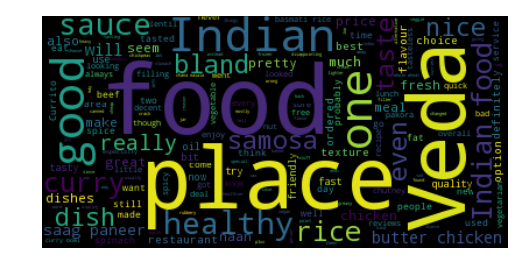

In [74]:
# check word cloud of some review

word_cloud(reviews_by_business_rescaled.select('text').rdd.take(1)[0][0])

In [75]:
# create a business_summary dataframe to be used for furher analysis

a = reviews_by_business_rescaled.alias("a")
b = business_df.alias("b")
    
bus_summary = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.business_name'),col('b.categories'),
                                                           col('b.stars'),col('b.review_count'),
                                                           col('b.latitude'),col('b.longitude')])
    

In [76]:
bus_summary.select('business_id', 'business_name','nostopwrd', 'feature', 'review_count', 'stars').show(1)

+--------------------+--------------------+--------------------+--------------------+------------+-----+
|         business_id|       business_name|           nostopwrd|             feature|review_count|stars|
+--------------------+--------------------+--------------------+--------------------+------------+-----+
|bfR-vJvrjdOJaWsXG...|Veda Healthy Indi...|[attention, aller...|(126299,[0,1,2,3,...|          27|  2.5|
+--------------------+--------------------+--------------------+--------------------+------------+-----+
only showing top 1 row



In [77]:
# check some bad reviews

bad_review = bus_summary.select('text') \
            .filter(bus_summary['stars'] == 1) \
            .rdd.take(3)[1][0]
bad_review

'The special sauce tastes terrible. Mashed potatoes are mediocre. The chicken isn\'t cooked properly and it was dry. Enough said. Do not waste your time and money.I should of followed my gut and walked out when I was saw at least 7 tables uncleared from the previous customers while we were being seated, but I thought I would give them the benefit of doubt.  To me, multiple tables with uncleared plates from previous customers screams bad management , which likely leads to bad service and food.   After being seated i waited to see just how long it took from the tables to be cleared. It wasn\'t until a manager came in yelling At a bus boy and forcing him to go To the tables did they finally get cleared.   A few minutes later our waitress came up and took our order, which was a smooth process.    Drinks were served timely and from there everything seemed ok. That is until the food came...  Orders were delivered for several people at our table with the explanation that they were "out of dar

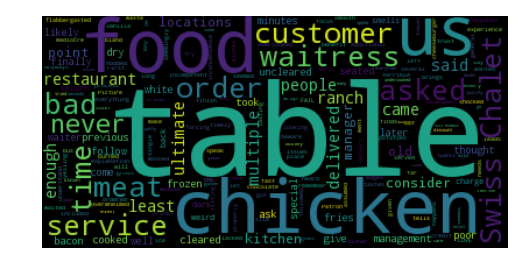

In [78]:
# word cloud for a bad review

word_cloud(bad_review)

In [79]:
# check some good reviews

good_review = bus_summary.select('text') \
            .filter(bus_summary['stars'] == 5) \
            .rdd.take(3)[1][0]
good_review

"Great New Spot in on Dundas, decor is well done. The basement wine cellar was hit with our table. The food was on point... Octopus was awesome. Great tunes as well. Its new they are working out some kinks, we are definitely heading back. Everyone enjoyed itDelicious food, good atmosphere! And they don't skimp on the alcohol in their cocktails..Brand new place cozy, great menu, amazing private room with a wine cellar Totally very exciting place for Dundas west and dufferin area"

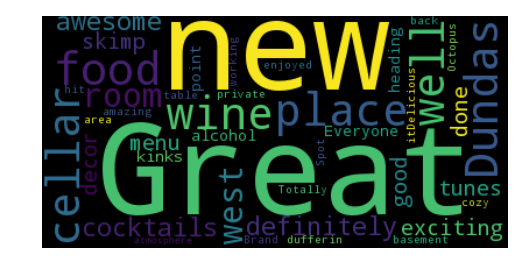

In [80]:
# word cloud for a good review

word_cloud(good_review)